In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances

# Problem 2: Clustering for Color Segmentation

In this problem, you will learn how to use clustering techniques to segment images.

*Color segmentation* is the task of partitioning an image into multiple segments. 
In *color segmentation*, all pixels that are part of the same segment get assigned to the same color.

Color segmentation is useful in many applications. 
In this homework assignment, you'll use color segmentation to compress an image (Part 1), and to identify regions of interest (Parts 2 and 3). 

## Part 1: Image compression

In a colored image, each pixel is of size 3 bytes (RGB), where each color can have intensity values from 0 to 255.
The total number of colors which can be represented is 256 x 256 x 256 = to 16,777,216.
Here, you will use k-means to reduce the number of colors needed to represent a colored digital image (this is known as **color quantization**).

In [26]:
# load the image
from matplotlib.image import imread
url = 'https://raw.githubusercontent.com/um-perez-alvaro/Data-Science-Theory/master/Data/St_Basil_Cathedral.png'
image = imread(url)[:,:,0:3]

<ipython-input-26-9185685b9d9c>:4: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  image = imread(url)[:,:,0:3]


The image is represented as a 3D array

In [27]:
image.shape

(600, 394, 3)

The first dimension's size is the height; the second is the width; and the third is the number of color channels, in this case red, green and blue (RGB)

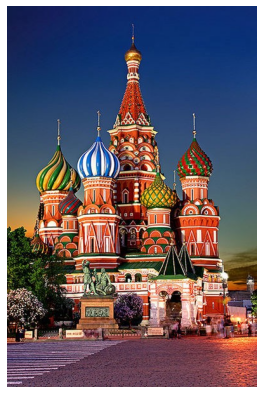

In [28]:
plt.figure(figsize=(17,7))
plt.imshow(image)
plt.axis('off')
plt.savefig('image.png')

The following cell reshapes the array to get a long list of RGB colors.
The resulting matrix X has one row for each pixel; 600x394=236400 rows (pixels) in total.

In [29]:
X = image.reshape(-1,3)
X.shape

(236400, 3)

Cluster the pixels (i.e., the rows of  X) using the k-means algorithm. 
Next, replace each pixel (i.e., each row of  X) by its cluster mean.
Plot the resulting image for k=2, 4, 6, 8, 10 and 12.

In [30]:
def kmeans(X,k,max_iterations=1000):
    from sklearn.metrics import pairwise_distances
    # initialize iteration counter
    it = 0
    repeat = True
    
    # number of datapoints
    m = X.shape[0] 
    
    # initialization
    means = X[np.random.choice(m,k,replace=False)] 
    dist = pairwise_distances(X,means)
    clusters = np.argmin(dist, axis=1)
 
    
    while repeat and it<max_iterations:
        
        # update means; # if a cluster has no data points associated with it, replace it with a random data point
        means = np.array([np.mean(X[clusters==i], axis=0) 
                          if np.sum(clusters==i)!=0
                          else  X[np.random.randint(m)]
                          for i in range(k)])
        
        # update clusters
        dist = pairwise_distances(X,means)
        new_clusters = np.argmin(dist, axis=1)
        
        # check if the new clusters are equal to the previous clusters
        if np.sum(clusters!=new_clusters)==0: 
            repeat = False
        clusters = new_clusters
                
        it += 1 # increment iteration counter by 1
    
    return clusters, means

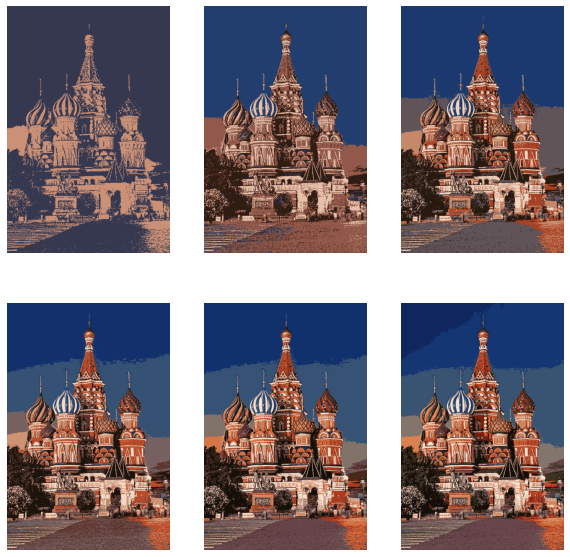

In [31]:
k_list = [2,4,6,8,10,12]
plt.figure(figsize=(10,10))
for i,k in enumerate(k_list):
    plt.subplot(2,3,i+1)
    clusters,means = kmeans(X,k)
    X_segmented = np.zeros(X.shape)
    for j in range(k):
        X_segmented[clusters==j]=means[j]
    plt.imshow(X_segmented.reshape(image.shape))
    plt.axis('off')

## Part 2: Identifying regions of interest

Color segmentation can be used to identify regions of interest and objects in an image.

In [32]:
# load the image
url = 'https://raw.githubusercontent.com/um-perez-alvaro/Data-Science-Theory/master/Data/cancer_cells.png'
image = imread(url)[:,:,0:3]

<ipython-input-32-bb456d4bdcea>:3: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  image = imread(url)[:,:,0:3]


The file *cancer_cells.png* is a digital image of a small section of a breast cancer mass.

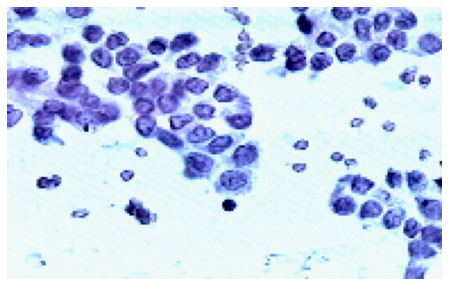

In [33]:
# display the image
plt.figure(figsize=(10,5))
plt.imshow(image)
plt.axis('off')
plt.savefig('image.png')

In [34]:
image.shape

(120, 192, 3)

In [35]:
X = image.reshape(-1,3)
X.shape

(23040, 3)

Here, you'll use k-means to isolate the cells from the background. 

First, cluster the pixels (i.e., the rows of  X) using the k-means algorithm with k=2. 
Next, color each pixel in cluster 0 in white (1,1,1), and each pixel in cluster 1 in black (0,0,0)
Finally, plot the resulting image.

In [36]:
clusters,means = kmeans(X,k=2)

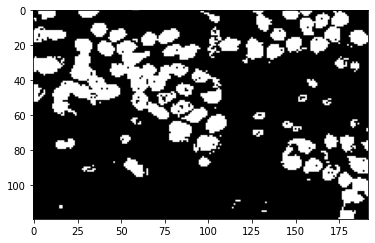

In [37]:
X_segmented = np.zeros(X.shape)
X_segmented[clusters==0]=[0,0,0]
X_segmented[clusters==1]=[1,1,1]
plt.imshow(X_segmented.reshape(image.shape))

## Part 3: detecting tumors

Here, you will try to segment an MRI image using the k-means clustering algorithm.

In [38]:
# load the image
url = 'https://raw.githubusercontent.com/um-perez-alvaro/Data-Science-Theory/master/Data/tumor.csv'
image = pd.read_csv(url,header=None).to_numpy()
image.shape

(571, 512)

The file `tumor.csv` corresponds to an MRI brain image of a patient with oligodendroglioma (a tumor that commonly
occurs in the front lobe of the brain)

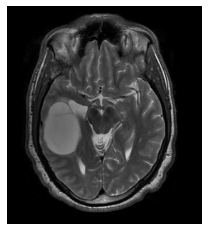

In [39]:
plt.imshow(image,cmap='gray')
plt.axis(False)
plt.show()

In [40]:
X = image.reshape(-1,1)
X.shape

(292352, 1)

Cluster the pixels, and ensure that you have a good number of clusters (using the "elbow" method, for example).

In [42]:
def inertia(X,means,clusters,k):
    m = len(clusters)
    return np.sum([np.sum((X[clusters==i]-means[i])**2) for i in range(k)])/m

Text(0, 0.5, 'inertia')

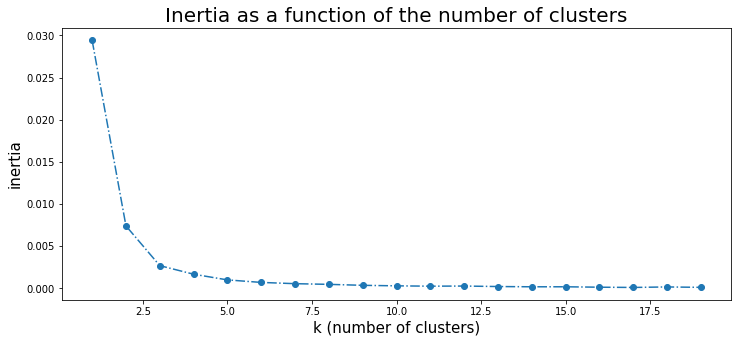

In [43]:
k_min = 1
k_max = 20
inertias = np.zeros(k_max-k_min)
for i,k in enumerate(range(k_min,k_max)):
    clusters,means = kmeans(X,k)
    inertias[i] = inertia(X,means,clusters,k)
    
plt.figure(figsize=(12,5))
plt.plot(range(k_min,k_max),inertias,'o-.')
plt.title('Inertia as a function of the number of clusters',fontsize=20)
plt.xlabel('k (number of clusters)', fontsize=15)
plt.ylabel('inertia', fontsize=15)

In [62]:
k = 3
clusters,means = kmeans(X,k)

Check that one of the clusters corresponds, more or less, to the tumor.

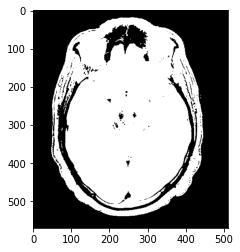

In [63]:
# cluster 0
X_segmented = np.zeros(X.shape)
X_segmented[clusters==0]=[1]
plt.imshow(X_segmented.reshape(image.shape),cmap='binary')

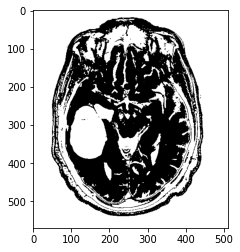

In [64]:
# cluster 1
X_segmented = np.zeros(X.shape)
X_segmented[clusters==1]=[1]
plt.imshow(X_segmented.reshape(image.shape),cmap='binary')

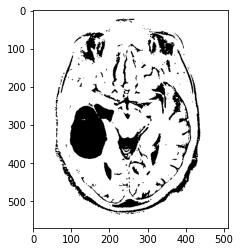

In [65]:
# cluster 2
X_segmented = np.zeros(X.shape)
X_segmented[clusters==2]=[1]
plt.imshow(X_segmented.reshape(image.shape),cmap='binary')